# Quick Start Guide

This tutorial shows how to quickly get started using *scarlet* to model an hyperspectral image cube. For a more in-depth introduction to *scarlet*, read the [Core Concepts](1-concepts.ipynb) or the [API Documentation](api/index.rst).

In [1]:
# Import Packages and setup
import numpy as np
import scarlet

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# use a good colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno', interpolation='none', origin='lower')

## Load and Display Data

We load an example data set (here an image cube with 5 bands) *and* a detection catalog.
If such a catalog is not available, packages like [SEP](http://sep.readthedocs.io/) and [photutils](https://photutils.readthedocs.io/en/stable/) will happily generate one, but for this example we use part of the detection catalog generated by the [LSST DM stack](https://github.com/lsst).

In [2]:
# Load the sample images
data = np.load("../data/hsc_cosmos_35.npz")
images = data["images"]
filters = data["filters"]
centers = [(src['y'], src['x']) for src in data["catalog"]] # Note: y/x convention!
weights = 1/data["variance"]
psf = scarlet.ImagePSF(data["psfs"])

### Display Image Cube

This is an example of how to display an RGB image from an image cube of multiband data. In this case the image uses a $sinh^{-1}$ function to normalize the flux in each filter consistently to create an RGB image.

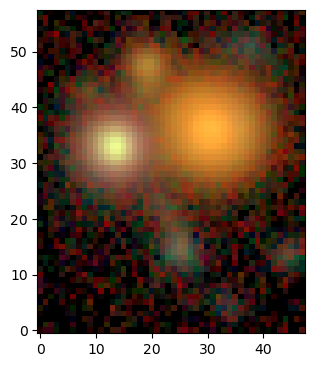

In [3]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)

img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)
plt.show()

## Define Model Frame and Observation

A `Frame` in *scarlet* is a description of the hyperspectral cube of the model or the observations. Think of it as the metadata, what aspects of the sky are described here. At the least, a `Frame` holds the `shape` of the cube, for which we use the convention `(C, Ny, Nx)` for the number of elements in 3 dimensions: `C` for the number of bands/channels and `Ny, Nx` for the number of pixels at every channel.

An `Observation` combines a `Frame` with several data units, similar to header-data arrangement in FITS files. In addition to the actual science image cube, you can and often must provide weights for all elements in the data cube, an image cube of the PSF model (one image for all or one for each channel), an `astropy.WCS` structure to translate from pixel to sky coordinates, and labels for all channels. The reason for specifying them is to enable the code to internally map from the model frame, in which you seek to fit a model, to the observed data frame.

In this example, we assume that bands and pixel locations are identical between the model and the observation. Because we have ground-based images with different PSFs in each band, we need to provide a reference PSF for the model. We simply choose a minimal Gaussian PSF that is barely well sampled as our reference kernel:

In [4]:
model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(filters))

With this we can fully specify the `Frame` and `Observation`:

In [5]:
model_frame = scarlet.Frame(
    images.shape,
    psf=model_psf,
    channels=filters)

observation = scarlet.Observation(
    images, 
    psf=psf,
    weights=weights, 
    channels=filters).match(model_frame)

The last command calls the `match` method to compute e.g. PSF difference kernel and filter transformations.

We generally recommend this pattern:
1. define model frame
2. construct observation
3. match it to the model frame

Steps 2 and 3 are combined above using a fluent pattern.

We can now make use of the convenience function `scarlet.display.show_observation` to plot observations as RGB images, with individual sources labeled at their position on the sky. It can also show the PSF in the same scaling.

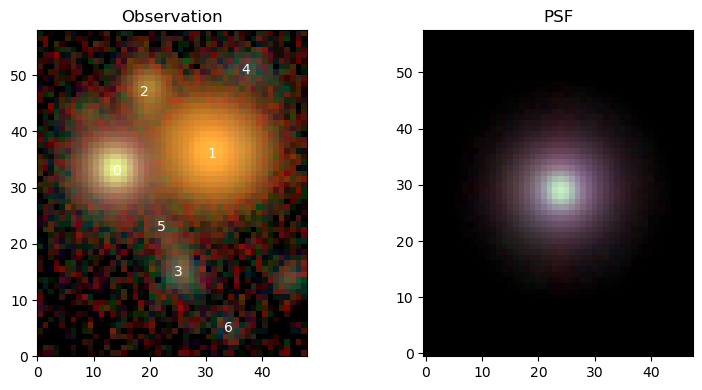

In [6]:
scarlet.display.show_observation(observation, norm=norm, sky_coords=centers, show_psf=True)
plt.show()

Since we use a trivial `wcs` in this `Observation`, all coordinates are already in image pixels, otherwise RA/Dec pairs are expected as sky coordinates.

## Initialize sources

You now need to define sources that are going to be fit. The full model, which we will call `Blend`, is a collection of those sources. We provide several pre-built source types, e.g.:

* `RandomSource` fits per-band amplitude and non-parametric morphology starting from uniform random draws for both.
* `PointSource` fits centers and per-band amplitude using the observed PSF model.
* `ExtendedSource` fits per-band amplitude and a non-parametric morphology (which is constrained to be monotonically decreasing from the center). It has a `compact` option, which initializes the source with the shape of a point source.
* `ExtendedSource(K=2)` splits an `ExtendedSource` into `K` components that are initially radially separated and stacked on top of each other like a pyramid.

We can use a robust initialization scheme, that starts by attempting to model every source with 2 components. If these components don't have enough signal-to-noise, it will fall back to 1 component. If that fails, it will work with a `compact` component. If cannot do even that, it will report the source number in `skipped`:

In [7]:
sources, skipped = scarlet.initialization.init_all_sources(model_frame, 
                                                           centers, 
                                                           observation, 
                                                           max_components=2, 
                                                           min_snr=50,
                                                           thresh=1,
                                                           fallback=True,
                                                           silent=True,
                                                           set_spectra=True
                                                          )

for k, src in enumerate(sources):
    print (f"{k}: {src.__class__.__name__}")

0: MultiExtendedSource
1: MultiExtendedSource
2: MultiExtendedSource
3: SingleExtendedSource
4: SingleExtendedSource
5: SingleExtendedSource
6: SingleExtendedSource


We can see that this method chooses multiple (here 2) extended components for the first three sources, a single extended component for sources 3 and 5, and compact ones for the rest.

If we know something about the scene, we might want to customize the modeling. Let's assume that we know that object 0 is a star. We could just replace that source with a `PointSource`, but for clarity we rebuild the entire source list, making one change for source 0 and accepting everything else from the default initialization above:

sources = []
for k,center in enumerate(centers):
    if k == 0:
        new_source = scarlet.PointSource(model_frame, center, observation)
    elif k in [1, 2]:
        new_source = scarlet.ExtendedSource(model_frame, center, observation, K=2)
    elif k in [3, 5]:
         new_source = scarlet.ExtendedSource(model_frame, center, observation, K=1)
    else:
         new_source = scarlet.ExtendedSource(model_frame, center, observation, compact=True)
    sources.append(new_source)

for k, src in enumerate(sources):
    print (f"{k}: {src.__class__.__name__}")

These sources are initialized independently, with spectra taken from their peak position in the observations. We can make another sweep and determine their spectra such that their superposition best matches the observation. Above, this was done for use by the option `set_specta=True`. But we can call the linear solver directly:

In [8]:
scarlet.initialization.set_spectra_to_match(sources, observation)

## Create and Fit Model

The `Blend` class holds the list of sources and has the machinery to fit them to the given images. In this example the code is set to run for a maximum of 100 iterations, but will end early if the likelihood and all the constraints converge.

CPU times: user 662 ms, sys: 22.8 ms, total: 685 ms
Wall time: 706 ms
scarlet ran for 50 iterations to logL = 30371.82193877243


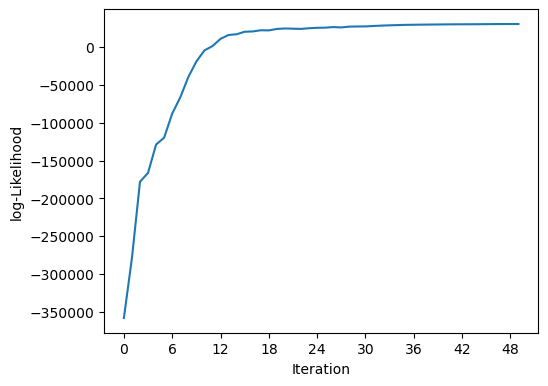

In [9]:
blend = scarlet.Blend(sources, observation)
%time it, logL = blend.fit(100, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

## Interact with Results

### View Full Scene

We could use `scarlet.display.show_scene` to render to entire scene, but it's instructive to see how the model and the comparison to observations is performed.
First we load the model for the entire scene, render it in the observation frame, and compute its residuals. We then show model and data with the same $sinh^{-1}$ stretch and the residuals with a linear stretch.

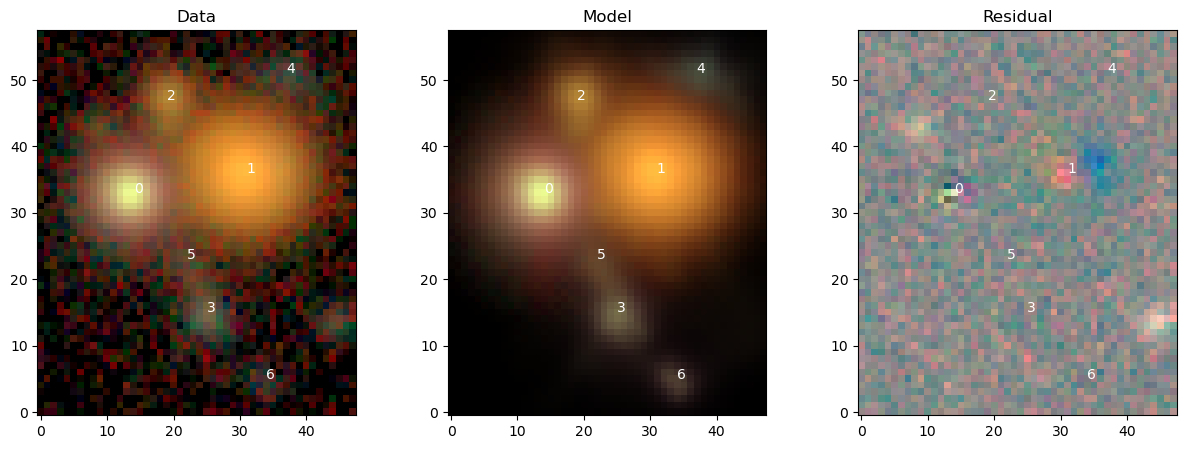

In [10]:
# Compute model
model = blend.get_model()
# Render it in the observed frame
model_ = observation.render(model)
# Compute residual
residual = images-model_

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,src in enumerate(blend):
    if hasattr(src, "center"):
        y,x = src.center
        ax[0].text(x, y, k, color="w")
        ax[1].text(x, y, k, color="w")
        ax[2].text(x, y, k, color="w")
plt.show()

### View Source Models


We will now inspect the model for each source, in its original frame and in its observed frame by leveraging the `show_sources` method:

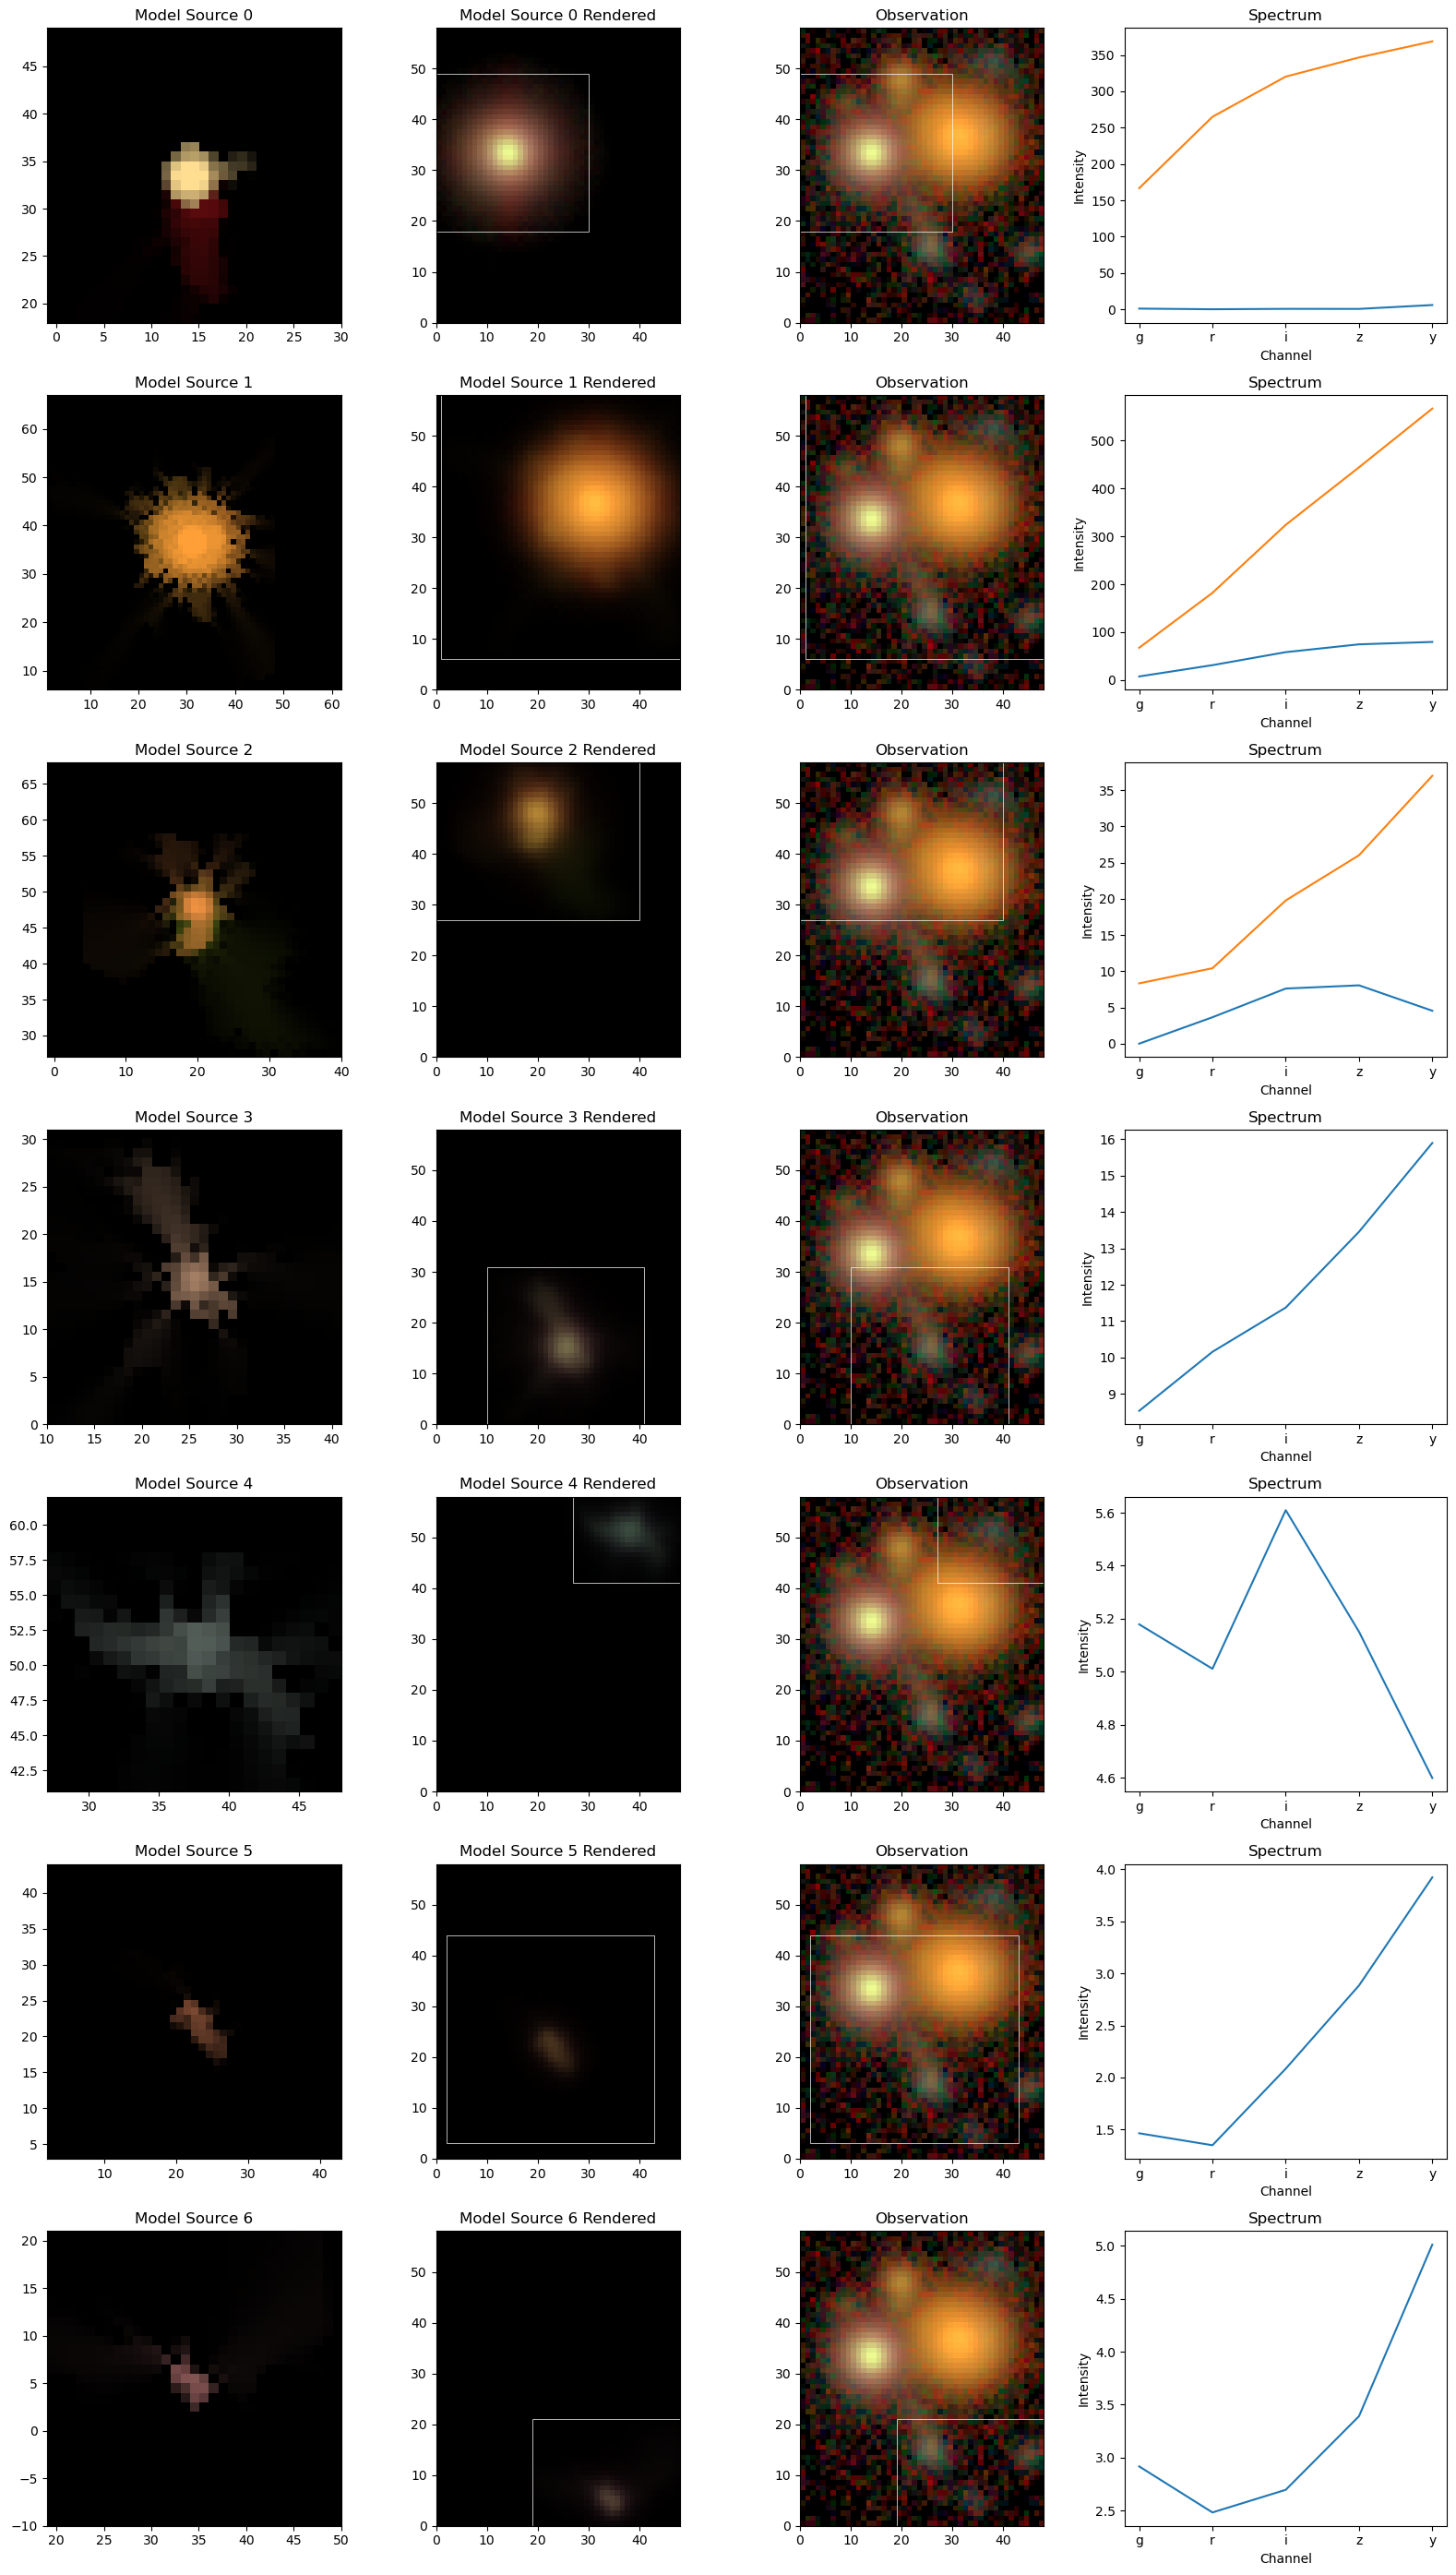

In [11]:
scarlet.display.show_sources(sources, 
                             norm=norm, 
                             observation=observation,
                             show_model=True,
                             show_rendered=True, 
                             show_observed=True,
                             add_markers=False,
                             add_boxes=True
                            )
plt.show()

We can see that each source "lives" in a smaller box and is then placed into the larger scene. The model of object 0 assumes the simple Gaussian shape of the model PSF, which is the internal representation of a point source. Source 1 uses the freedom of the 2-compoent model to represent a slightly redder core; the difference in spectrum is clearly noticeable.

### Measure Fluxes

The color information in these plots stems from the per-band amplitude, which are computed from the hyperspectral model by integrating over the morphology. The source spectra plots in the right panels above have done exactly that. The convention of these fluxes is given by the units and ordering of the original data cube. In the case of multi-component sources, the fluxes of all components are combined.

In [12]:
print ("----------------- {}".format(filters))
for k, src in enumerate(sources):
    print ("Source {}, Fluxes: {}".format(k, scarlet.measure.flux(src)))

----------------- ['g' 'r' 'i' 'z' 'y']
Source 0, Fluxes: [167.53129002 264.99694475 320.85668577 347.16224875 374.60743885]
Source 1, Fluxes: [ 75.20066394 213.41260579 382.51691677 518.98311381 646.4901738 ]
Source 2, Fluxes: [ 8.32385126 14.05450517 27.37449382 34.06289295 41.5183003 ]
Source 3, Fluxes: [ 8.53207009 10.15608496 11.37306792 13.45834823 15.90049206]
Source 4, Fluxes: [5.17893922 5.0111677  5.60966035 5.15088369 4.5988445 ]
Source 5, Fluxes: [1.46472715 1.34983023 2.08462937 2.8836367  3.92074657]
Source 6, Fluxes: [2.91625798 2.48162727 2.69534285 3.3909824  5.01191201]


Other measurements (e.g. `centroid`) are also implemented. The measurement approach is also easily extendable. The source models are generated in the model frame (which is the best-fit representation of the full hyperspectral `Frame`), from which any measurement can directly be made without having to deal with noise, PSF convolution, overlapping sources, etc. 

### Save and Re-Use Model

To preserve the model for posterity, individual sources or lists of sources can be serialized with the `pickle` library:

In [13]:
import pickle
fp = open("hsc_cosmos_35.sca", "wb")
pickle.dump(sources, fp)
fp.close()

The pickled file can be reopened in the same way. Every source can be utilized as before.

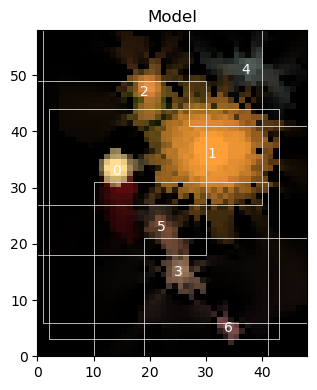

In [14]:
fp = open("hsc_cosmos_35.sca", "rb")
sources_ = pickle.load(fp)
fp.close()

scarlet.display.show_scene(sources_, norm=norm, add_boxes=True)
plt.show()

However, if we want to refit some data with this model, we have to recreate a `Blend` instance.

We will now add two more sources to account for the largest residuals we have seen above. As we don't know their location accurately, we allow the fitter to shift/recenter the sources.

CPU times: user 812 ms, sys: 18.5 ms, total: 830 ms
Wall time: 845 ms
scarlet ran for 53 iterations to logL = 31740.68718897289


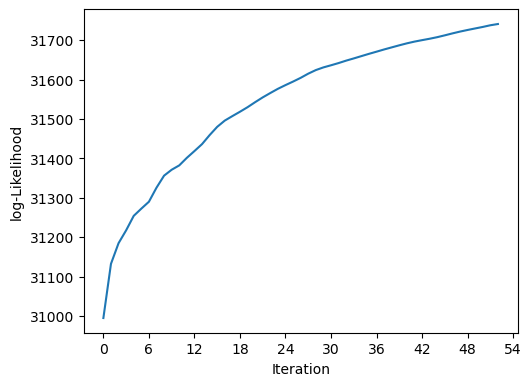

In [15]:
# add two sources at their approximate locations
model_frame_ = sources_[0].frame
yx = (14., 44.)
new_source = scarlet.ExtendedSource(model_frame_, yx, observation, compact=True, shifting=True)
sources_.append(new_source)
yx = (42., 9.)
new_source = scarlet.ExtendedSource(model_frame_, yx, observation, compact=True, shifting=True)
sources_.append(new_source)

# generate a new Blend instance
blend_ = scarlet.Blend(sources_, observation)
# tighten relative change in likelihood for convergence
%time it_, logL_ = blend_.fit(100, e_rel=1e-4)
print(f"scarlet ran for {it_} iterations to logL = {logL_}")
scarlet.display.show_likelihood(blend_)
plt.show()

We can see that logL is slightly higher than before. Let's have a look at the new model:

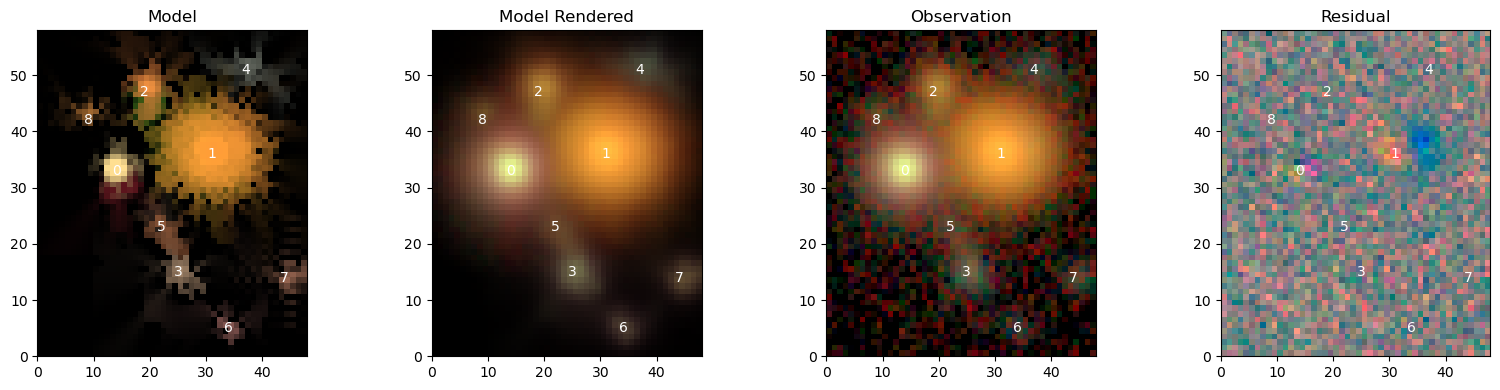

In [16]:
scarlet.display.show_scene(sources_, 
                           norm=norm, 
                           observation=observation, 
                           show_rendered=True, 
                           show_observed=True, 
                           show_residual=True)
plt.show()

We can see the two new sources 7 and 8, and that most of the features are very similar to before. As expected, the residuals have visibly improved and are now dominated by a red-blue pattern in the center of source 1, which we already fit with 2 components. Maybe we should try with 3 ...